## Tutorial for RNA to ATAC Cross-Modality Generation Step 1

Hi, this is the tutorial for RNA to ATAC(denoted as R2A) cross-modality generation. We take the MISAR-seq dataset as an example in this task. Detailed results about this task will be found in figure 3 in our paper.

To be specific, our model input is three types of data: 
* a set of paired spatial multi-omics data from the same slice (denoted as S1R and S1A in our paper and figure 1) 
* a single-modality spatial data from another slice (denoted as S2R in our paper and figure 1) 

Our target is to generate the missing modality for S2, that is S2A.

To complete this task, we need to take several steps:

(1) Batch Correction. Considering the huge batch effect between slices, we first need to remove batch effects between the same modality of different slices (i.e. S1R and S2R). After this step, we will get two latent embeddings without batch for two slices respectively.

(2) Modality Pretrain. We need to get the embedding for another modality (S1A).

(3) Cross Generation. We use the two paired embeddings from S1A and S1R and train the generative model.

(4) Inference: After training the model, we freeze all the parameters and use the embedding from S2R and input it through the frozen network from (3). Once we get the generated embedding, we use the frozen decoder from (2) and get the final whole matrix, called S2 R2A_predict.

We divide the whole process into 2 files. This file is step 1, which is batch correction module. After running this ipynb file, please go to step 2 to do generation task.

## Preparation

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [2]:
import SpaTranslator as spt


    _____               ______                           __        __              
   / ___/ ____   ____ _/_  __/_____ ____ _ ____   _____ / /____ _ / /_ ____   _____
   \__ \ / __ \ / __ `/ / /  / ___// __ `// __ \ / ___// // __ `// __// __ \ / ___/
  ___/ // /_/ // /_/ / / /  / /   / /_/ // / / /(__  )/ // /_/ // /_ / /_/ // /    
 /____// .___/ \__,_/ /_/  /_/    \__,_//_/ /_//____//_/ \__,_/ \__/ \____//_/     
      /_/                                                                           

SpaTranslator v1.0.8     



## Load Data, Graph Construction and Preprocessing

In [3]:
import os
os.chdir('/home/yourworkpath/SpatialTranslator')

In [5]:
Batch_list = []
adj_list = []
section_ids = ['E15_5-S1_expr','E15_5-S2_expr']
for section_id in section_ids:
    print(section_id)
    input_dir = 'To_train_' + section_id
    adata = sc.read_h5ad(input_dir + '.h5ad')
    adata.var_names_make_unique()
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    spt.build_spatial_graph(adata, knn_neighbors = 6, method ='KNN') 
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]
    adj_list.append(adata.uns['adj_matrix'])
    Batch_list.append(adata)
    print(adata.shape)

E15_5-S1_expr
Constructing the spatial graph
Generated graph with 11694 edges across 1949 cells.
Average neighbors per cell: 6.0000
(1949, 10000)
E15_5-S2_expr
Constructing the spatial graph
Generated graph with 11634 edges across 1939 cells.
Average neighbors per cell: 6.0000
(1939, 10000)


We concat the scanpy objects for multiple slices

In [6]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (3888, 4075)


We concat the spatial network for multiple slices

In [7]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))


In [8]:
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

In [9]:
batch_labels = np.array(adata_concat.obs['batch_name'].unique())
edge_data = adata_concat.uns['edgeList']

## Train the model


In [10]:
adata_concat = spt.train_spatial_aligner(adata_concat, verbose=True, knn_neighbors = 50, device=used_device)

SpaTranslator_Aligner(
  (encoder_layer1): GraphAttentionLayer(4075, 512, heads=1)
  (encoder_layer2): GraphAttentionLayer(512, 128, heads=1)
  (decoder_layer1): GraphAttentionLayer(128, 512, heads=1)
  (decoder_layer2): GraphAttentionLayer(512, 4075, heads=1)
)
Pretraining


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 190.99it/s]


Training with MNN loss


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:52<00:00,  1.71it/s]


In [11]:
adata_concat

AnnData object with n_obs × n_vars = 3888 × 4075
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRa

## Showing Result 

We use the following code to get the aligned embeddings and plot them in 2D-UMAP to see that whether they are aligned well.

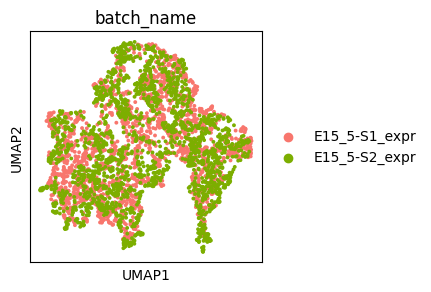

In [12]:
sc.pp.neighbors(adata_concat, use_rep='AlignedEmbedding', random_state=666)
sc.tl.umap(adata_concat, random_state=666)
section_color = ['#f8766d', '#7cae00']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_concat, color='batch_name',ncols = 1,
           wspace=0.5, show=True)

## Save the Results and Embeddings

In [13]:
E15_S1 = sc.read_h5ad('To_train_' + 'E15_5-S1'+ '_expr.h5ad')
E15_S1
E15_S1.obsm['AlignedEmbedding'] = adata_concat.obsm['AlignedEmbedding'][0:1949, :]
E15_S1.write_h5ad('After_train_' + 'E15_5-S1' + '_expr.h5ad')

In [14]:
E15_S2 = sc.read_h5ad('To_train_' + 'E15_5-S2'+ '_expr.h5ad')
E15_S2
E15_S2.obsm['AlignedEmbedding'] = adata_concat.obsm['AlignedEmbedding'][1949:, :]
E15_S2.write_h5ad('After_train_' + 'E15_5-S2' + '_expr.h5ad')